<a href="https://colab.research.google.com/github/Alanazi433/GenAI/blob/main/GenAI/HW4/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"husamalanazi","key":"a5865ad0a2918f25bbd3811f421d4cef"}'}

In [ ]:
!kaggle datasets download -d jhoward/lsun_bedroom
!unzip lsun_bedroom.zip -d lsun_bedroom


Streaming output truncated to the last 5000 lines.
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd5fedec227994c1816b44f2ca9f3e82c6d7443.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd6160588fd3dc9e06b4288690d1d9ee0b541c6.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd6c84b1a3d3db0749222146c7fa4b5311f8d9f.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd6f96b894e3dedbcb629e7ed9f8f5b32b70581.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd713f5f784867f8e0d6eb45af0b24e2b98dcdd.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd7217f9d2fba8cea938a35c928741e361911fd.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd742d13cde6954f0a18564a91c8b901be140e2.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd7a210da182506c1cde48d7585bef758056f5d.jpg  
  inflating: lsun_bedroom/sample/data0/lsun/bedroom/f/b/d/fbd7d7c87c4c622c539cab278cf0516fa666ec3f.jpg  
  in

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras import layers
from tqdm import tqdm
import shutil


In [ ]:
# Define source and subset directories
source_dir = '/content/lsun_bedroom/sample/data0/lsun/bedroom'
subset_dir = '/content/lsun_bedroom_subset'
os.makedirs(subset_dir, exist_ok=True)

# Search for images with common extensions in all subdirectories
valid_extensions = ('.jpg', '.jpeg', '.png')
all_images = [os.path.join(root, file)
              for root, _, files in os.walk(source_dir)
              for file in files if file.lower().endswith(valid_extensions)]

# Set sample size, considering the total image count
num_images = 5000  # Increased dataset size for better results
num_images = min(num_images, len(all_images))
selected_images = random.sample(all_images, num_images)

# Copy selected images to the subset directory
for img_path in selected_images:
    shutil.copy(img_path, subset_dir)

print(f"Created a subset with {num_images} images.")


Created a subset with 5000 images.


In [ ]:
dataset_dir = '/content/lsun_bedroom_subset'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=(128, 128),  # Updated to 128x128
    batch_size=64,
    label_mode=None,
    shuffle=True
)

# Normalize images to [-1, 1]
def normalize_images(images):
    return (images - 127.5) / 127.5

dataset = dataset.map(lambda x: normalize_images(x), num_parallel_calls=tf.data.AUTOTUNE)


Found 5000 files.


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# Test the generator's output shape
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print("Generator output shape:", generated_image.shape)  # Should output (1, 128, 128, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator output shape: (1, 128, 128, 3)


In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# Test the discriminator with a sample input
sample_image = tf.random.normal([1, 128, 128, 3])  # Dummy image for testing
print("Discriminator output shape:", discriminator(sample_image).shape)  # Should output (1, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Discriminator output shape: (1, 1)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([128, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradient clipping
    gradients_of_generator = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_generator]
    gradients_of_discriminator = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_discriminator]

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss = disc_loss = None
        for image_batch in tqdm(dataset):
            gen_loss, disc_loss = train_step(image_batch)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')

        # Save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype("uint8"))
        plt.axis("off")

    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.show()


100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 1, Gen Loss: 3.7844743728637695, Disc Loss: 0.5090469121932983


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 2, Gen Loss: 1.08012056350708, Disc Loss: 1.2651828527450562


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 3, Gen Loss: 1.275693416595459, Disc Loss: 0.837597131729126


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 4, Gen Loss: 0.9522808790206909, Disc Loss: 1.263114333152771


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 5, Gen Loss: 0.7461175918579102, Disc Loss: 0.9905812740325928


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 6, Gen Loss: 0.9250039458274841, Disc Loss: 0.8231849670410156


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 7, Gen Loss: 0.9809916019439697, Disc Loss: 1.105279803276062


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 8, Gen Loss: 0.7610788941383362, Disc Loss: 1.1634304523468018


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 9, Gen Loss: 0.8470945954322815, Disc Loss: 1.7225611209869385


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 10, Gen Loss: 0.8989241123199463, Disc Loss: 1.0722122192382812


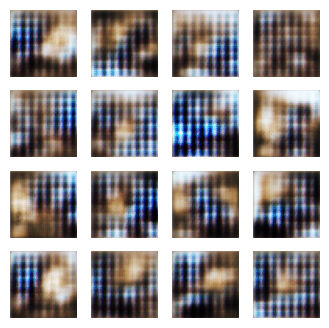

100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 11, Gen Loss: 0.8748490214347839, Disc Loss: 1.060086727142334


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 12, Gen Loss: 0.9121279716491699, Disc Loss: 1.1183714866638184


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 13, Gen Loss: 0.8457522392272949, Disc Loss: 1.275158166885376


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 14, Gen Loss: 1.0741355419158936, Disc Loss: 1.0833020210266113


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 15, Gen Loss: 0.9523743391036987, Disc Loss: 1.0026507377624512


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 16, Gen Loss: 0.9123018980026245, Disc Loss: 1.083308458328247


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 17, Gen Loss: 0.978003740310669, Disc Loss: 1.33440101146698


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 18, Gen Loss: 1.0923347473144531, Disc Loss: 1.341577172279358


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 19, Gen Loss: 1.2004601955413818, Disc Loss: 0.9716436862945557


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 20, Gen Loss: 1.4674266576766968, Disc Loss: 1.0705629587173462


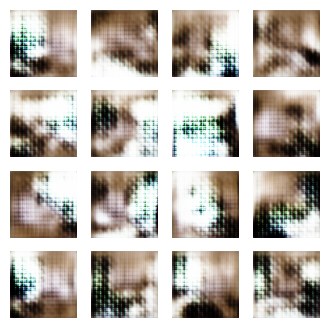

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 21, Gen Loss: 1.3203926086425781, Disc Loss: 1.1122475862503052


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 22, Gen Loss: 1.115070104598999, Disc Loss: 1.4502696990966797


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 23, Gen Loss: 1.4212291240692139, Disc Loss: 0.7362827062606812


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 24, Gen Loss: 0.8959057331085205, Disc Loss: 0.8858612775802612


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 25, Gen Loss: 0.9632492065429688, Disc Loss: 1.211216688156128


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 26, Gen Loss: 1.137825846672058, Disc Loss: 0.8802745342254639


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 27, Gen Loss: 2.2431256771087646, Disc Loss: 0.4333869516849518


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 28, Gen Loss: 1.9658379554748535, Disc Loss: 0.7559784054756165


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 29, Gen Loss: 3.2546327114105225, Disc Loss: 0.6084052324295044


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 30, Gen Loss: 1.901755928993225, Disc Loss: 0.6384629011154175


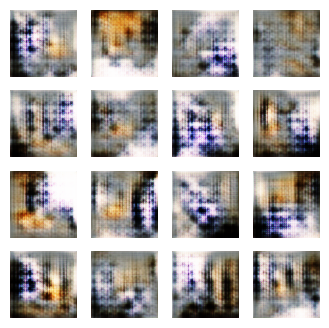

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 31, Gen Loss: 2.4256787300109863, Disc Loss: 0.9805805087089539


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 32, Gen Loss: 4.615674018859863, Disc Loss: 0.5800251960754395


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 33, Gen Loss: 2.460635185241699, Disc Loss: 0.48362696170806885


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 34, Gen Loss: 2.804994821548462, Disc Loss: 0.34270578622817993


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 35, Gen Loss: 1.2675238847732544, Disc Loss: 0.664273738861084


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 36, Gen Loss: 1.8099439144134521, Disc Loss: 0.4584331512451172


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 37, Gen Loss: 3.660991668701172, Disc Loss: 0.5628697872161865


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 38, Gen Loss: 0.8767525553703308, Disc Loss: 1.1603190898895264


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 39, Gen Loss: 2.1543784141540527, Disc Loss: 0.2766897976398468


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 40, Gen Loss: 2.093068838119507, Disc Loss: 0.37506991624832153


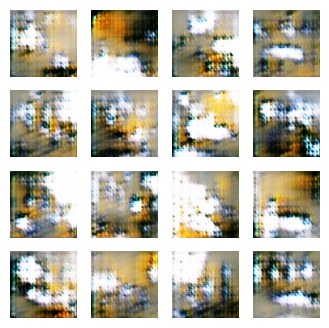

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 41, Gen Loss: 1.8646807670593262, Disc Loss: 0.3456629514694214


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 42, Gen Loss: 2.460968017578125, Disc Loss: 0.4663317799568176


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 43, Gen Loss: 3.2832183837890625, Disc Loss: 0.18122342228889465


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 44, Gen Loss: 2.8675856590270996, Disc Loss: 0.36995646357536316


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 45, Gen Loss: 2.69276762008667, Disc Loss: 0.5013140439987183


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 46, Gen Loss: 1.6139769554138184, Disc Loss: 0.46371427178382874


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 47, Gen Loss: 2.134725332260132, Disc Loss: 0.7113382816314697


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 48, Gen Loss: 4.576383590698242, Disc Loss: 0.3396660089492798


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 49, Gen Loss: 2.3407020568847656, Disc Loss: 0.4692891836166382


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 50, Gen Loss: 5.657663345336914, Disc Loss: 0.6389920115470886


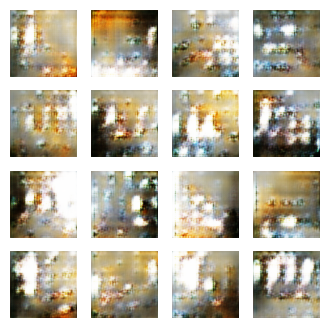

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 51, Gen Loss: 1.2587300539016724, Disc Loss: 0.5924630761146545


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 52, Gen Loss: 1.100034236907959, Disc Loss: 1.100774884223938


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 53, Gen Loss: 2.681293249130249, Disc Loss: 0.19285215437412262


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 54, Gen Loss: 1.9858677387237549, Disc Loss: 0.8391640186309814


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 55, Gen Loss: 3.029005527496338, Disc Loss: 0.35780707001686096


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 56, Gen Loss: 1.5472171306610107, Disc Loss: 0.7163416743278503


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 57, Gen Loss: 2.326292037963867, Disc Loss: 0.4938829839229584


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 58, Gen Loss: 2.183661699295044, Disc Loss: 0.8868199586868286


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 59, Gen Loss: 1.6947212219238281, Disc Loss: 0.445541650056839


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 60, Gen Loss: 2.725005626678467, Disc Loss: 0.20407702028751373


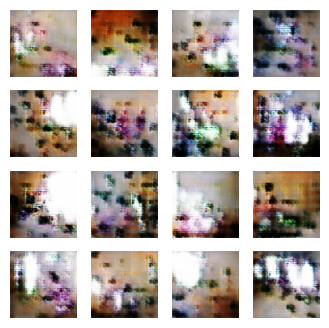

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 61, Gen Loss: 3.104649543762207, Disc Loss: 0.148380309343338


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 62, Gen Loss: 1.705456018447876, Disc Loss: 0.31878405809402466


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 63, Gen Loss: 2.4226021766662598, Disc Loss: 0.23105531930923462


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 64, Gen Loss: 0.9431663751602173, Disc Loss: 1.16576087474823


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 65, Gen Loss: 2.891587018966675, Disc Loss: 0.302568256855011


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 66, Gen Loss: 2.32123064994812, Disc Loss: 0.7205231189727783


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 67, Gen Loss: 3.420105218887329, Disc Loss: 0.15760692954063416


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 68, Gen Loss: 3.0292210578918457, Disc Loss: 0.2206050306558609


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 69, Gen Loss: 2.3874640464782715, Disc Loss: 0.532446026802063


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 70, Gen Loss: 3.0712103843688965, Disc Loss: 0.28991755843162537


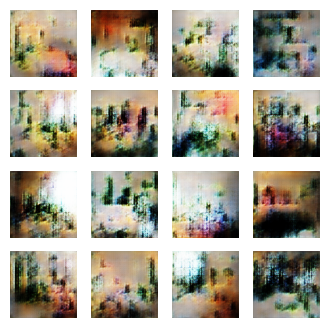

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 71, Gen Loss: 2.770536422729492, Disc Loss: 0.22919055819511414


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 72, Gen Loss: 4.497305870056152, Disc Loss: 0.5316786766052246


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 73, Gen Loss: 4.196269989013672, Disc Loss: 0.05986783653497696


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 74, Gen Loss: 6.085171699523926, Disc Loss: 0.02738136239349842


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 75, Gen Loss: 2.4745428562164307, Disc Loss: 0.4850870966911316


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 76, Gen Loss: 3.4089231491088867, Disc Loss: 1.0552127361297607


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 77, Gen Loss: 3.2991437911987305, Disc Loss: 0.08825790882110596


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 78, Gen Loss: 4.223141193389893, Disc Loss: 0.04243579879403114


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 79, Gen Loss: 3.013758659362793, Disc Loss: 0.4240171015262604


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 80, Gen Loss: 3.8944461345672607, Disc Loss: 0.13911165297031403


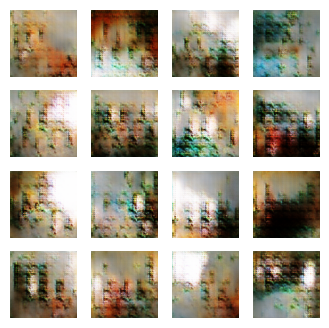

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 81, Gen Loss: 3.0406486988067627, Disc Loss: 0.13407739996910095


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 82, Gen Loss: 5.320950984954834, Disc Loss: 0.5468522310256958


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 83, Gen Loss: 2.8724138736724854, Disc Loss: 0.21848993003368378


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 84, Gen Loss: 4.916438579559326, Disc Loss: 0.12636613845825195


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 85, Gen Loss: 3.0802741050720215, Disc Loss: 0.16885223984718323


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 86, Gen Loss: 3.133425712585449, Disc Loss: 0.11666078865528107


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 87, Gen Loss: 4.693761825561523, Disc Loss: 0.05549974739551544


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 88, Gen Loss: 3.126708984375, Disc Loss: 0.16613906621932983


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 89, Gen Loss: 3.2125611305236816, Disc Loss: 0.290037602186203


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 90, Gen Loss: 3.829951047897339, Disc Loss: 0.21488291025161743


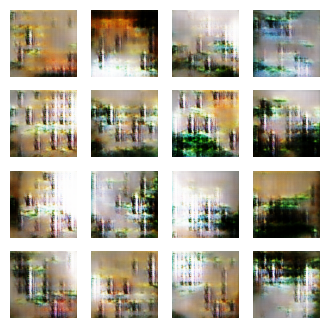

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 91, Gen Loss: 4.25222110748291, Disc Loss: 0.4323696494102478


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 92, Gen Loss: 3.947307586669922, Disc Loss: 0.46218520402908325


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 93, Gen Loss: 2.511695623397827, Disc Loss: 0.8454636931419373


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 94, Gen Loss: 3.1032614707946777, Disc Loss: 0.6466143131256104


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 95, Gen Loss: 3.050349235534668, Disc Loss: 0.12979136407375336


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 96, Gen Loss: 2.952176094055176, Disc Loss: 0.2778867483139038


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 97, Gen Loss: 3.428204298019409, Disc Loss: 0.15205584466457367


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 98, Gen Loss: 3.3561830520629883, Disc Loss: 0.24162375926971436


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 99, Gen Loss: 6.189636707305908, Disc Loss: 0.27353107929229736


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 100, Gen Loss: 4.831243515014648, Disc Loss: 0.3317115306854248


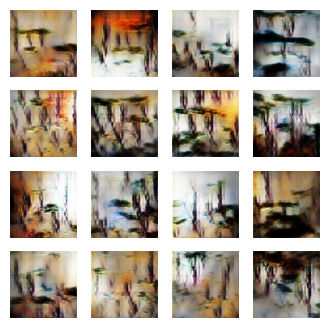

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 101, Gen Loss: 2.9393539428710938, Disc Loss: 0.4981895089149475


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 102, Gen Loss: 4.060399055480957, Disc Loss: 0.07972550392150879


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 103, Gen Loss: 5.068999290466309, Disc Loss: 0.09350693225860596


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 104, Gen Loss: 5.55607795715332, Disc Loss: 0.19809818267822266


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 105, Gen Loss: 2.390425205230713, Disc Loss: 0.34614336490631104


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 106, Gen Loss: 2.6625096797943115, Disc Loss: 0.6891881227493286


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 107, Gen Loss: 3.1345372200012207, Disc Loss: 0.28038692474365234


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 108, Gen Loss: 2.7054343223571777, Disc Loss: 0.2279515415430069


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 109, Gen Loss: 3.790757179260254, Disc Loss: 0.23950396478176117


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 110, Gen Loss: 5.416522979736328, Disc Loss: 0.2508593797683716


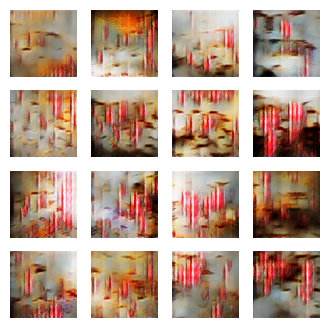

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 111, Gen Loss: 2.3703818321228027, Disc Loss: 0.3490805923938751


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 112, Gen Loss: 3.157036781311035, Disc Loss: 0.15174143016338348


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 113, Gen Loss: 1.8246111869812012, Disc Loss: 0.560639500617981


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 114, Gen Loss: 2.7916009426116943, Disc Loss: 0.18521463871002197


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 115, Gen Loss: 3.4947526454925537, Disc Loss: 0.06002887338399887


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 116, Gen Loss: 2.6885945796966553, Disc Loss: 0.3674790859222412


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 117, Gen Loss: 2.3827507495880127, Disc Loss: 0.39592403173446655


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 118, Gen Loss: 2.5910792350769043, Disc Loss: 0.25258803367614746


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 119, Gen Loss: 7.339719295501709, Disc Loss: 0.08014026284217834


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 120, Gen Loss: 4.794277191162109, Disc Loss: 0.3704315423965454


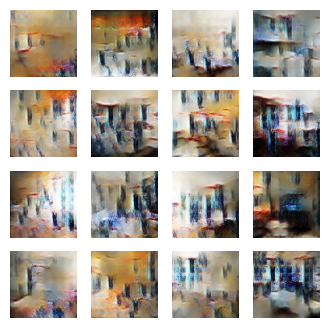

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 121, Gen Loss: 2.8008673191070557, Disc Loss: 0.48928844928741455


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 122, Gen Loss: 3.309643268585205, Disc Loss: 0.23281605541706085


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 123, Gen Loss: 5.73307991027832, Disc Loss: 0.5832773447036743


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 124, Gen Loss: 3.5463945865631104, Disc Loss: 0.10025054961442947


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 125, Gen Loss: 3.7728707790374756, Disc Loss: 0.31485357880592346


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 126, Gen Loss: 3.269620180130005, Disc Loss: 0.11279791593551636


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 127, Gen Loss: 3.9682464599609375, Disc Loss: 0.09806915372610092


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 128, Gen Loss: 3.034776210784912, Disc Loss: 0.12056619673967361


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 129, Gen Loss: 4.295275688171387, Disc Loss: 0.30997729301452637


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 130, Gen Loss: 3.83579683303833, Disc Loss: 0.10467895120382309


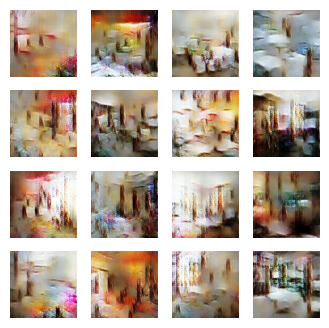

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 131, Gen Loss: 3.2549686431884766, Disc Loss: 0.405434787273407


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 132, Gen Loss: 3.615140199661255, Disc Loss: 0.8548315763473511


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 133, Gen Loss: 3.5918753147125244, Disc Loss: 0.07187830656766891


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 134, Gen Loss: 2.79653263092041, Disc Loss: 0.25831764936447144


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 135, Gen Loss: 3.865306854248047, Disc Loss: 0.33183756470680237


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 136, Gen Loss: 3.381279468536377, Disc Loss: 0.15647657215595245


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 137, Gen Loss: 3.6089766025543213, Disc Loss: 0.32700517773628235


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 138, Gen Loss: 4.154881477355957, Disc Loss: 0.2804473340511322


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 139, Gen Loss: 4.327255725860596, Disc Loss: 0.2251766324043274


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 140, Gen Loss: 2.2890288829803467, Disc Loss: 0.24779580533504486


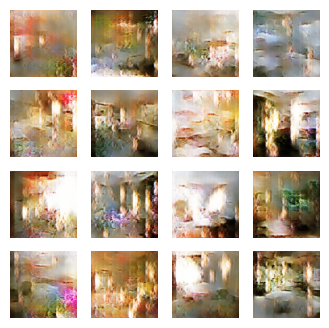

100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 141, Gen Loss: 4.384716987609863, Disc Loss: 0.09846922755241394


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 142, Gen Loss: 2.7034339904785156, Disc Loss: 0.34473496675491333


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 143, Gen Loss: 3.0031919479370117, Disc Loss: 0.3102397918701172


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 144, Gen Loss: 3.0814008712768555, Disc Loss: 0.6136561632156372


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 145, Gen Loss: 3.561384916305542, Disc Loss: 0.31293821334838867


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 146, Gen Loss: 3.8496742248535156, Disc Loss: 0.6673939824104309


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 147, Gen Loss: 7.354898452758789, Disc Loss: 1.5826687812805176


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 148, Gen Loss: 3.1081738471984863, Disc Loss: 0.16330476105213165


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 149, Gen Loss: 3.612335681915283, Disc Loss: 0.17670562863349915


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 150, Gen Loss: 3.4263620376586914, Disc Loss: 0.20157520473003387


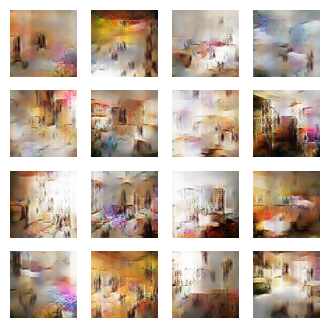

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 151, Gen Loss: 2.765655755996704, Disc Loss: 0.17158018052577972


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 152, Gen Loss: 4.532008171081543, Disc Loss: 0.544121265411377


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 153, Gen Loss: 6.751070499420166, Disc Loss: 0.14393407106399536


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 154, Gen Loss: 3.991079092025757, Disc Loss: 0.17076855897903442


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 155, Gen Loss: 4.95138692855835, Disc Loss: 0.132193461060524


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 156, Gen Loss: 3.708782196044922, Disc Loss: 0.14997568726539612


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 157, Gen Loss: 3.472391128540039, Disc Loss: 0.09281779080629349


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 158, Gen Loss: 3.007370948791504, Disc Loss: 0.4244399666786194


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 159, Gen Loss: 2.8840441703796387, Disc Loss: 0.4052674174308777


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 160, Gen Loss: 5.9105658531188965, Disc Loss: 0.09334178268909454


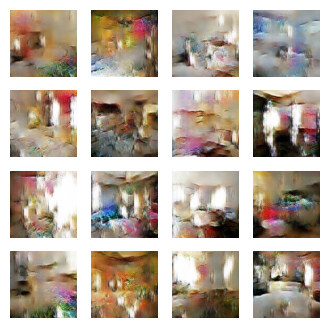

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 161, Gen Loss: 4.319523811340332, Disc Loss: 0.27596375346183777


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 162, Gen Loss: 3.0614850521087646, Disc Loss: 0.2022128701210022


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 163, Gen Loss: 3.7798919677734375, Disc Loss: 0.2835955023765564


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 164, Gen Loss: 2.0224215984344482, Disc Loss: 0.34558016061782837


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 165, Gen Loss: 4.930263519287109, Disc Loss: 0.5713694095611572


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch 166, Gen Loss: 4.1052141189575195, Disc Loss: 0.24483197927474976


100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch 167, Gen Loss: 3.121572732925415, Disc Loss: 0.2034159153699875


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 168, Gen Loss: 3.7970526218414307, Disc Loss: 0.09311996400356293


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 169, Gen Loss: 6.134067058563232, Disc Loss: 0.45514607429504395


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 170, Gen Loss: 3.476895332336426, Disc Loss: 0.26526743173599243


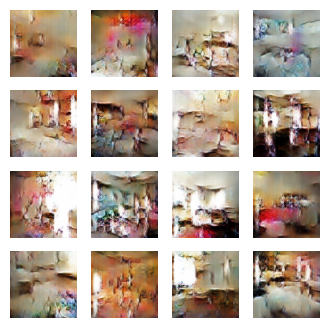

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 171, Gen Loss: 3.325640916824341, Disc Loss: 0.47084861993789673


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 172, Gen Loss: 4.905975818634033, Disc Loss: 0.04242296144366264


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch 173, Gen Loss: 3.294379711151123, Disc Loss: 0.18871952593326569


100%|██████████| 79/79 [00:59<00:00,  1.32it/s]


Epoch 174, Gen Loss: 4.777529716491699, Disc Loss: 0.13151942193508148


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 175, Gen Loss: 2.974112033843994, Disc Loss: 0.25664761662483215


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 176, Gen Loss: 5.95280647277832, Disc Loss: 0.08097590506076813


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 177, Gen Loss: 3.143611192703247, Disc Loss: 0.1396695077419281


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 178, Gen Loss: 2.5292069911956787, Disc Loss: 0.4090447425842285


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 179, Gen Loss: 6.229377746582031, Disc Loss: 0.20455054938793182


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 180, Gen Loss: 2.7112770080566406, Disc Loss: 0.5239189863204956


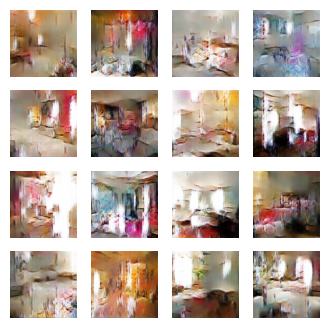

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 181, Gen Loss: 2.593533992767334, Disc Loss: 0.3105037212371826


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 182, Gen Loss: 3.5014634132385254, Disc Loss: 0.16311919689178467


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 183, Gen Loss: 2.079768180847168, Disc Loss: 0.5833368301391602


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 184, Gen Loss: 2.184281826019287, Disc Loss: 0.34465208649635315


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 185, Gen Loss: 3.143634796142578, Disc Loss: 0.44799405336380005


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 186, Gen Loss: 2.9795937538146973, Disc Loss: 0.21882139146327972


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 187, Gen Loss: 3.1165246963500977, Disc Loss: 0.25981763005256653


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 188, Gen Loss: 2.7276370525360107, Disc Loss: 0.46767133474349976


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 189, Gen Loss: 4.596549987792969, Disc Loss: 0.2626248300075531


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 190, Gen Loss: 5.9654436111450195, Disc Loss: 0.6681495308876038


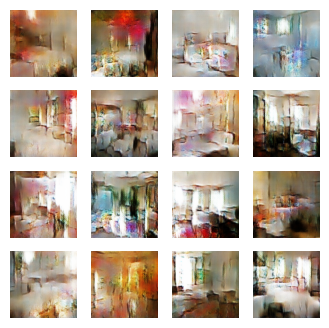

100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 191, Gen Loss: 5.369328022003174, Disc Loss: 0.08538811653852463


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 192, Gen Loss: 4.012723922729492, Disc Loss: 1.1562803983688354


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 193, Gen Loss: 1.843523383140564, Disc Loss: 0.5393235683441162


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 194, Gen Loss: 3.742718458175659, Disc Loss: 0.22806482017040253


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 195, Gen Loss: 2.1845712661743164, Disc Loss: 0.38024580478668213


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 196, Gen Loss: 3.8295116424560547, Disc Loss: 0.29390203952789307


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 197, Gen Loss: 4.613849639892578, Disc Loss: 0.7245456576347351


100%|██████████| 79/79 [00:59<00:00,  1.34it/s]


Epoch 198, Gen Loss: 4.103408336639404, Disc Loss: 0.3304083049297333


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 199, Gen Loss: 2.4002933502197266, Disc Loss: 0.41951748728752136


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


Epoch 200, Gen Loss: 4.020340919494629, Disc Loss: 0.20217090845108032


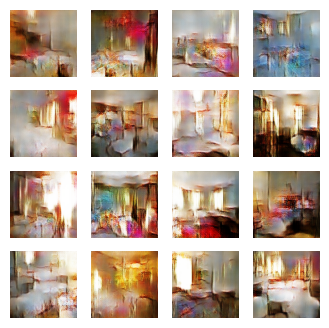

In [ ]:
EPOCHS = 200  # Extended training for better quality
seed = tf.random.normal([16, 100])
train(dataset, EPOCHS)


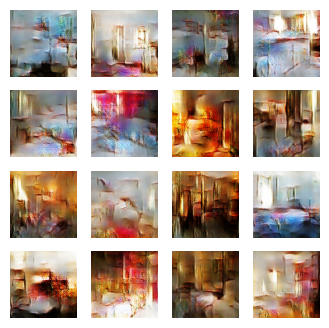

In [ ]:
def generate_images(generator, num_images=16):
    noise = tf.random.normal([num_images, 100])
    generated_images = generator(noise, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((generated_images[i] * 127.5 + 127.5).numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

generate_images(generator)
